# Sunitha Nagrath Lab (notebook 2)

In [1]:
!pip install pandas numpy tensorflow scikit-learn matplotlib seaborn joblib

In [2]:
# c&p from notebook 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# 1. Merge and Adjust Data Sets

## Adjust EM Files

In [3]:
# Adjust EM_files

# Load the CSV files
EM_memb = pd.read_csv('fixed_old_datasets/E_memb.csv')
EM_nuclei = pd.read_csv('fixed_old_datasets/E.csv')

# Drop rows where "Annotation" is empty
EM_memb = EM_memb.dropna(subset=['Annotation'])
EM_nuclei = EM_nuclei.dropna(subset=['Annotation'])

# Concatinate "Memb." to column names beyond "Annotation" for EM_memb
EM_memb.columns = list(EM_memb.columns[:3]) + ['Memb.' + col for col in EM_memb.columns[3:]]

# Concatinate "Nuclei." to column names beyond "Annotation" for EM_nuc
EM_nuclei.columns = list(EM_nuclei.columns[:3]) + ['Nue.' + col for col in EM_nuclei.columns[3:]]

# Merge EM_memb and EM_nuclei on "ObjectNumber" and "Annotation"
EM = pd.merge(EM_memb, EM_nuclei, on=['ObjectNumber', 'Annotation'])

# Replace "ImageNumber_x" column name with "BaseFile". Fill value
EM = EM.rename(columns={'ImageNumber_x': 'BaseFile'})
EM['BaseFile'] = 'EM_file'

# Print head
print(EM.head())

  BaseFile  ObjectNumber Annotation  Memb.AreaShape_Area  \
0  EM_file             3          E                 5270   
1  EM_file             3          E                 5270   
2  EM_file             3          E                 5270   
3  EM_file             4          E                 5093   
4  EM_file             5          E                 7616   

   Memb.AreaShape_BoundingBoxArea  Memb.AreaShape_BoundingBoxMaximum_X  \
0                            8774                                 1277   
1                            8774                                 1277   
2                            8774                                 1277   
3                            8010                                 1180   
4                           13420                                 1190   

   Memb.AreaShape_BoundingBoxMaximum_Y  Memb.AreaShape_BoundingBoxMinimum_X  \
0                                  310                                 1170   
1                                  3

## Adjust M Files

In [4]:
# Adjust M_files

# Load the CSV files
M_memb = pd.read_csv('fixed_old_datasets/MyExpt_FilteredCells_with_annotation_additional_corresponding_cell.csv')
M_nuclei = pd.read_csv('fixed_old_datasets/MyExpt_FilteredNuclei_nei_annotated_additional_corresponding_cell.csv')

# For M_memb, replace the third column name with "Annotation"
M_memb.columns = list(M_memb.columns[:2]) + ['Annotation'] + list(M_memb.columns[3:])

# Drop rows where "Annotation" is empty
M_memb = M_memb.dropna(subset=['Annotation'])
M_nuclei = M_nuclei.dropna(subset=['Annotation'])

# Concatinate "Memb." to column names beyond "Annotation" for EM_memb
M_memb.columns = list(M_memb.columns[:3]) + ['Memb.' + col for col in M_memb.columns[3:]]

# Concatinate "Nuclei." to column names beyond "Annotation" for EM_nuc
M_nuclei.columns = list(M_nuclei.columns[:3]) + ['Nue.' + col for col in M_nuclei.columns[3:]]

# Merge EM_memb and EM_nuclei on "ObjectNumber" and "Annotation"
M = pd.merge(M_memb, M_nuclei, on=['ObjectNumber', 'Annotation'])

# Replace "ImageNumber_x" column name with "BaseFile". Fill value
M = M.rename(columns={'ImageNumber_x': 'BaseFile'})
M['BaseFile'] = 'M_file'

# Print head
print(M.head())

  BaseFile  ObjectNumber Annotation  Memb.AreaShape_Area  \
0   M_file             1          M                 4198   
1   M_file             1          M                 4198   
2   M_file             3          M                 4945   
3   M_file             3          M                 4945   
4   M_file             4          M                 6059   

   Memb.AreaShape_BoundingBoxArea  Memb.AreaShape_BoundingBoxMaximum_X  \
0                           10787                                  949   
1                           10787                                  949   
2                           11600                                 1277   
3                           11600                                 1277   
4                           14429                                 2237   

   Memb.AreaShape_BoundingBoxMaximum_Y  Memb.AreaShape_BoundingBoxMinimum_X  \
0                                  222                                  882   
1                                  2

# Merge

In [5]:
# Merge EM and M

# 合并数据
final_combined_data1 = pd.concat([M, EM], ignore_index=True)

# 查看合并后的数据
print(final_combined_data1)

# 保存合并后的数据
final_combined_data1.to_csv('final_combined_data1.csv', index=False)


    BaseFile  ObjectNumber Annotation  Memb.AreaShape_Area  \
0     M_file             1          M                 4198   
1     M_file             1          M                 4198   
2     M_file             3          M                 4945   
3     M_file             3          M                 4945   
4     M_file             4          M                 6059   
..       ...           ...        ...                  ...   
219  EM_file            17          M                 5135   
220  EM_file            18          M                 3688   
221  EM_file            21          M                 7505   
222  EM_file            21          M                 7505   
223  EM_file            26          M                 3158   

     Memb.AreaShape_BoundingBoxArea  Memb.AreaShape_BoundingBoxMaximum_X  \
0                             10787                                  949   
1                             10787                                  949   
2                          

# 2. PCA and PL-SDA on Data1 and Apply it to Data2 (Combined_Data.csv)

## Fit PCA

### X_old_scaled

In [6]:
# Prepare features
X_old = final_combined_data1.drop(columns=['ObjectNumber', 'Annotation', 'BaseFile'])

# Drop columns "_NormalizedMoment_0_0", "_NormalizedMoment_1_0", and "_NormalizedMoment_0_1" since it only contains NaN values
columns_to_drop = ['Memb.AreaShape_NormalizedMoment_0_0',
                   'Memb.AreaShape_NormalizedMoment_0_1',
                   'Memb.AreaShape_NormalizedMoment_1_0',
                   'Nue.AreaShape_NormalizedMoment_0_0',
                   'Nue.AreaShape_NormalizedMoment_0_1',
                   'Nue.AreaShape_NormalizedMoment_1_0']
columns_to_drop = [col for col in columns_to_drop if col in X_old.columns]
X_old = X_old.drop(columns=columns_to_drop)

# Scalar
scaler = StandardScaler()
X_old_scaled = scaler.fit_transform(X_old)

In [7]:
# PCA (Principal Component Analysis) is a dimensionality reduction technique 
# that transforms the data into a new coordinate system, where the axes 
# (principal components) correspond to directions of maximum variance in the data.

# create PCA model
pca = PCA(n_components=2)
X_old_pca = pca.fit_transform(X_old_scaled)

# X_pca would have a shape of (n_samples, n_components)
print("n_samples = ", X_old_scaled.shape[0])
print("X_pca shape: ", X_old_pca.shape)

# y = annotation
y = final_combined_data1['Annotation'].values

# Print out explained variance ratio
print("Explained variance ratio: ", pca.explained_variance_ratio_)

n_samples =  224
X_pca shape:  (224, 2)
Explained variance ratio:  [0.19623857 0.08795676]


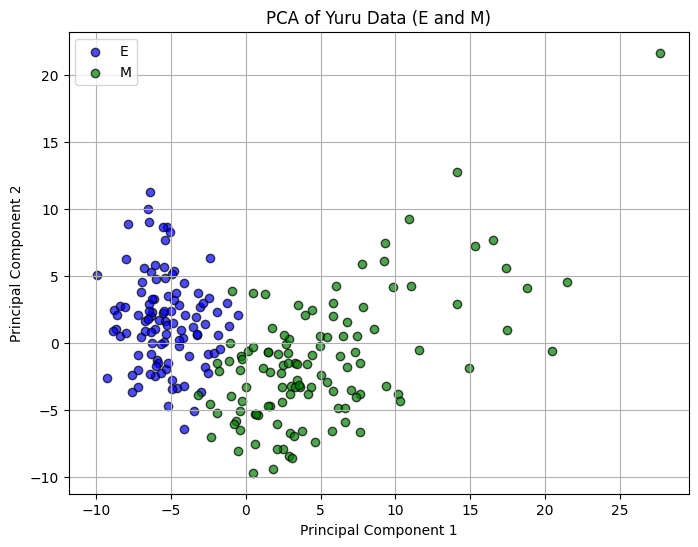

In [19]:
# plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_old_pca[y == 'E', 0], X_old_pca[y == 'E', 1], c='blue', label='E', alpha=0.7, edgecolor='k')
plt.scatter(X_old_pca[y == 'M', 0], X_old_pca[y == 'M', 1], c='green', label='M', alpha=0.7, edgecolor='k')
plt.title('PCA of Yuru Data (E and M)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/pca_on_data1.png", format='png', bbox_inches='tight')
plt.close()

## Apply PCA Space to New Data

### X_new_scaled

In [9]:
# Load new data from Combined_Data.csv
final_combined_data2 = pd.read_csv('Combined_Data.csv')

# Prepare features
X_new = final_combined_data2.drop(columns=['ImageNumber', 'ObjectNumber', 'Annotation'])

# Drop columns "_NormalizedMoment_0_0", "_NormalizedMoment_1_0", and "_NormalizedMoment_0_1" since it only contains NaN values
columns_to_drop = ['Memb.AreaShape_NormalizedMoment_0_0',
                   'Memb.AreaShape_NormalizedMoment_0_1',
                   'Memb.AreaShape_NormalizedMoment_1_0',
                   'Nue.AreaShape_NormalizedMoment_0_0',
                   'Nue.AreaShape_NormalizedMoment_0_1',
                   'Nue.AreaShape_NormalizedMoment_1_0']
columns_to_drop = [col for col in columns_to_drop if col in X_new.columns]
X_new = X_new.drop(columns=columns_to_drop)

# Scalar
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)

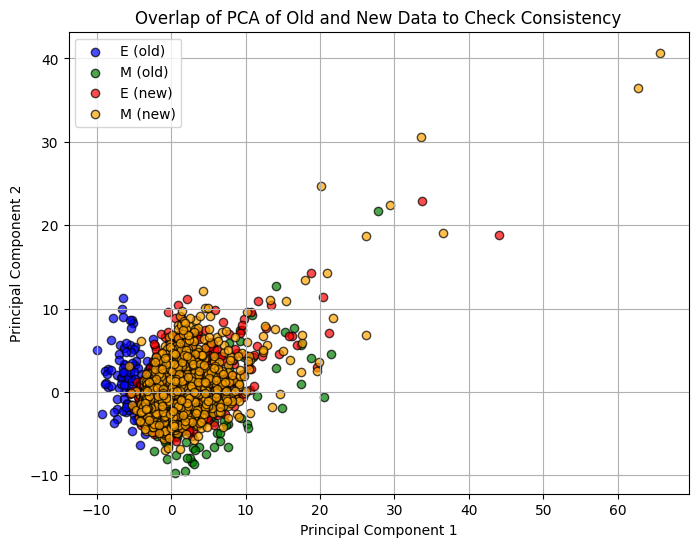

Plot Shows that the PCA space of New and Old data matches!


In [10]:
# Transform the old and new data using the fitted PCA
X_new_pca = pca.transform(X_new_scaled)  # New data projected into the old PCA space

# y = annotation
y_new = final_combined_data2['Annotation'].values

# Compare the PCA results of the old and new data
plt.figure(figsize=(8, 6))
plt.scatter(X_old_pca[y == 'E', 0], X_old_pca[y == 'E', 1], c='blue', label='E (old)', alpha=0.7, edgecolor='k')
plt.scatter(X_old_pca[y == 'M', 0], X_old_pca[y == 'M', 1], c='green', label='M (old)', alpha=0.7, edgecolor='k')
plt.scatter(X_new_pca[y_new == 'E', 0], X_new_pca[y_new == 'E', 1], c='red', label='E (new)', alpha=0.7, edgecolor='k')
plt.scatter(X_new_pca[y_new == 'M', 0], X_new_pca[y_new == 'M', 1], c='orange', label='M (new)', alpha=0.7, edgecolor='k')
plt.title('Overlap of PCA of Old and New Data to Check Consistency')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/compare_pca_old_and_pca_new.png", format='png', bbox_inches='tight')
plt.close()

print('Plot Shows that the PCA space of New and Old data matches!')

## Fit PLS-DA

In [11]:
# PLS-DA (Partial Least Squares Discriminant Analysis) is a supervised method
# that projects the data into a new coordinate system that maximizes the separation
# between classes. It is often used for classification tasks.

# basically a supervised version of PCA

# Encode the annotations to numerical values
le = LabelEncoder()
y_old = final_combined_data1['Annotation'].values
y_old_encoded = le.fit_transform(y_old)

# Create PLS-DA model
pls_da = PLSRegression(n_components=2)
X_old_pls_da = pls_da.fit_transform(X_old_scaled, y_old_encoded)[0]

# X_pls_da would have a shape of (n_samples, n_components)
print("n_samples = ", X_old_scaled.shape[0])
print("X_pls_da shape: ", X_old_pls_da.shape)

# Print out component weights
print("Component weights: ", pls_da.x_weights_)

n_samples =  224
X_pls_da shape:  (224, 2)
Component weights:  [[-3.00156193e-02 -9.33855451e-02]
 [-8.71308871e-02 -8.99177106e-02]
 [-3.24812922e-02 -2.25163954e-02]
 [ 9.52661861e-03 -1.98712264e-02]
 [-2.47889285e-02 -2.16021065e-02]
 [ 1.91753342e-02 -1.41250454e-02]
 [-2.86788790e-02 -2.26114373e-02]
 [ 1.41298964e-02 -1.72472863e-02]
 [-3.00156193e-02 -9.33855451e-02]
 [-1.51176719e-02 -1.66208367e-02]
 [-6.24893009e-02 -7.50370652e-02]
 [-8.11299580e-03  5.80182190e-02]
 [-2.57706941e-03  1.00355717e-01]
 [ 2.10930217e-04  1.80899259e-02]
 [ 1.15352484e-02  2.66220868e-02]
 [ 7.73965262e-03  1.68055512e-02]
 [-6.51202976e-02 -1.03599687e-01]
 [ 3.20166813e-02  1.41894249e-01]
 [-5.38712678e-02 -1.39303542e-01]
 [ 1.29824245e-02  1.17578571e-01]
 [-1.28819028e-01 -1.44422529e-02]
 [-6.42615803e-02 -9.62182133e-02]
 [-1.27982823e-01  6.85397836e-02]
 [-2.75290622e-02 -9.15568685e-02]
 [-0.00000000e+00  0.00000000e+00]
 [ 1.43412886e-01 -7.69836439e-02]
 [ 1.51642108e-01 -7.921930

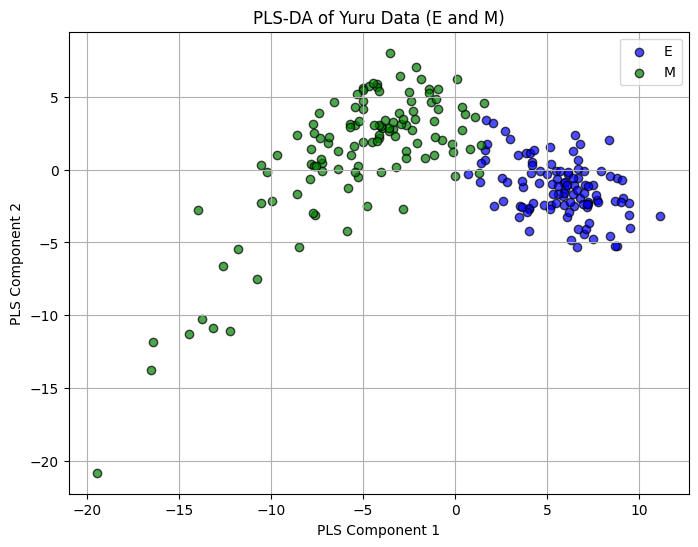

In [12]:
# plot the PLS-DA results
plt.figure(figsize=(8, 6))
plt.scatter(X_old_pls_da[y == 'E', 0], X_old_pls_da[y == 'E', 1], c='blue', label='E', alpha=0.7, edgecolor='k')
plt.scatter(X_old_pls_da[y == 'M', 0], X_old_pls_da[y == 'M', 1], c='green', label='M', alpha=0.7, edgecolor='k')
plt.title('PLS-DA of Yuru Data (E and M)')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/pls-da_on_old_data.png", format='png', bbox_inches='tight')
plt.close()

## Apply PLS-DA Space to New data

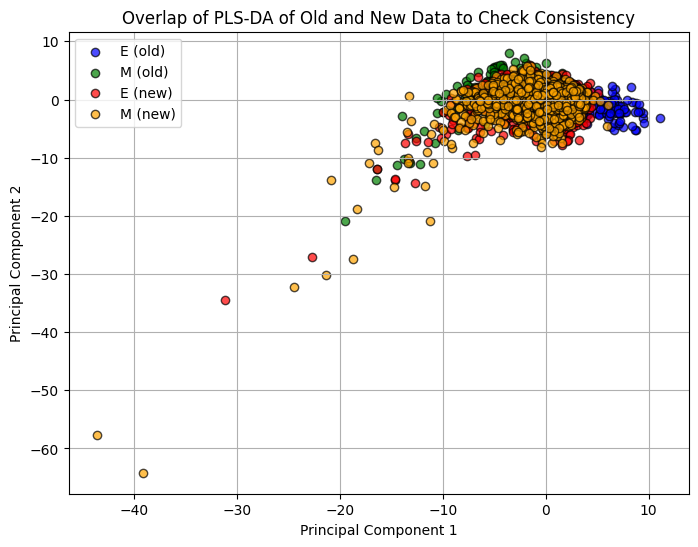

Plot Shows that the PCA space of New and Old data matches!


In [13]:
# y = annotation
y_new = final_combined_data2['Annotation'].values
y_new_encoded = le.fit_transform(y_new)

# Transform the old and new data using the fitted PLS-DA
X_new_pls_da = pls_da.transform(X_new_scaled)  # New data projected into the old PLS-DA space

# Compare the PLS-DA results of the old and new data
plt.figure(figsize=(8, 6))
plt.scatter(X_old_pls_da[y == 'E', 0], X_old_pls_da[y == 'E', 1], c='blue', label='E (old)', alpha=0.7, edgecolor='k')
plt.scatter(X_old_pls_da[y == 'M', 0], X_old_pls_da[y == 'M', 1], c='green', label='M (old)', alpha=0.7, edgecolor='k')
plt.scatter(X_new_pls_da[y_new == 'E', 0], X_new_pls_da[y_new == 'E', 1], c='red', label='E (new)', alpha=0.7, edgecolor='k')
plt.scatter(X_new_pls_da[y_new == 'M', 0], X_new_pls_da[y_new == 'M', 1], c='orange', label='M (new)', alpha=0.7, edgecolor='k')
plt.title('Overlap of PLS-DA of Old and New Data to Check Consistency')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
# save plot
plt.savefig("Metrics/compare_pls-da_old_and_pls-da_new.png", format='png', bbox_inches='tight')
plt.close()

print('Plot Shows that the PCA space of New and Old data matches!')

# 3. Train Dicision Tree Model

## Fit Model

In [14]:
# Create a Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_old_scaled, y_old)

# Predict the test set
y_pred = dt.predict(X_old_scaled)

# Compute the confusion matrix
cm = confusion_matrix(y, y_pred, labels=['E', 'M'])

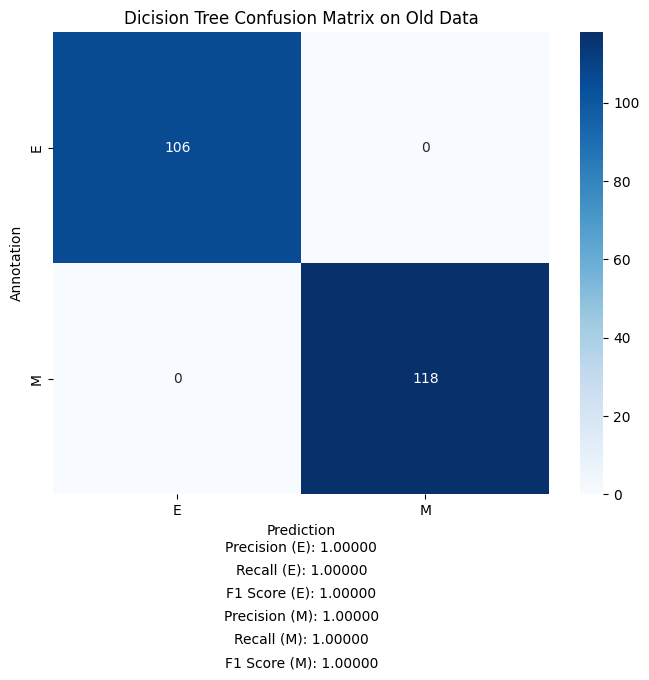

In [15]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
plt.ylabel('Annotation')
plt.xlabel('Prediction')
plt.title('Dicision Tree Confusion Matrix on Old Data')

# Calculate precision, recall, and F1 score for each class
precision_e = precision_score(y, y_pred, pos_label='E', average='binary')
recall_e = recall_score(y, y_pred, pos_label='E', average='binary')
f1_e = f1_score(y, y_pred, pos_label='E', average='binary')

# Display metrics for 'E' state in the plot
plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Calculate metrics for 'M' state
precision_m = precision_score(y, y_pred, pos_label='M', average='binary')
recall_m = recall_score(y, y_pred, pos_label='M', average='binary')
f1_m = f1_score(y, y_pred, pos_label='M', average='binary')

# Display metrics for 'M' state in the plot
plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Save the confusion matrix plot
plt.savefig("Metrics/dt_on_old_data_confusion_matrix.png", format='png', bbox_inches='tight')
plt.show()
plt.close()  # Free memory by closing figure

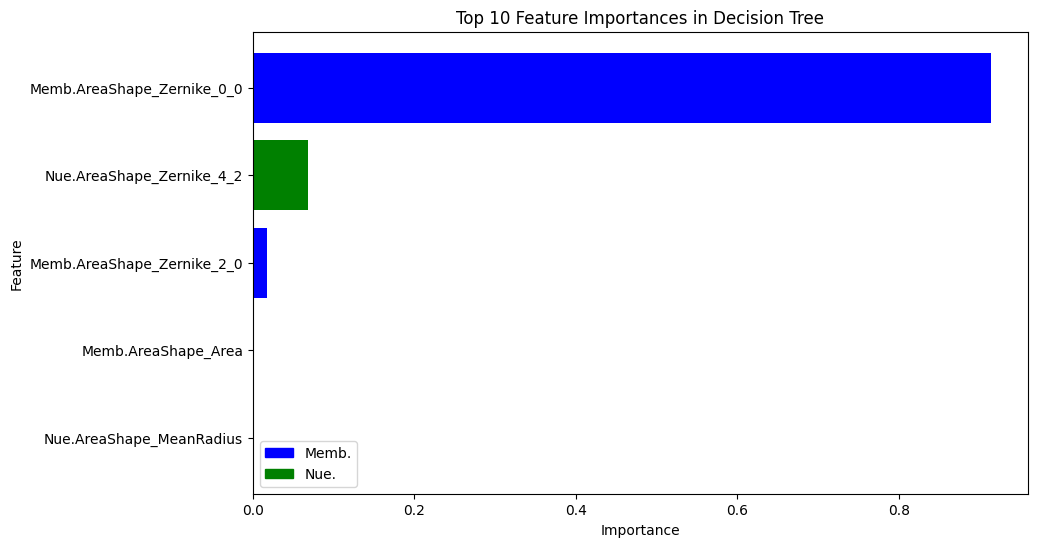

In [39]:
# Extract feature importances
feature_importances = dt.feature_importances_

# Create a DataFrame for better visualization
X_old_df = pd.DataFrame(X_old)
features_df = pd.DataFrame({
    'Feature': X_old_df.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance and keep only the top 10
top_features_df = features_df.sort_values(by='Importance', ascending=False).head(5)

# Define colors based on feature names
colors = ['blue' if 'Memb.' in feature else 'green' for feature in top_features_df['Feature']]

# Plot the top 10 feature importances with separate colors
plt.figure(figsize=(10, 6))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances in Decision Tree')
plt.gca().invert_yaxis()

# Create custom legend handles
blue_patch = mpatches.Patch(color='blue', label='Memb.')
green_patch = mpatches.Patch(color='green', label='Nue.')

# Add legend to the plot
plt.legend(handles=[blue_patch, green_patch])

plt.show()

# Save the feature importances plot
plt.savefig("Metrics/dt_on_old_data_feature_importances.png", format='png', bbox_inches='tight')
plt.close()  # Free memory by closing figure

## Apply Model to New Data

In [17]:
# Apply model to new data
y_new_pred = dt.predict(X_new_scaled)

# Compute the confusion matrix
cm_new = confusion_matrix(y_new, y_new_pred, labels=['E', 'M'])

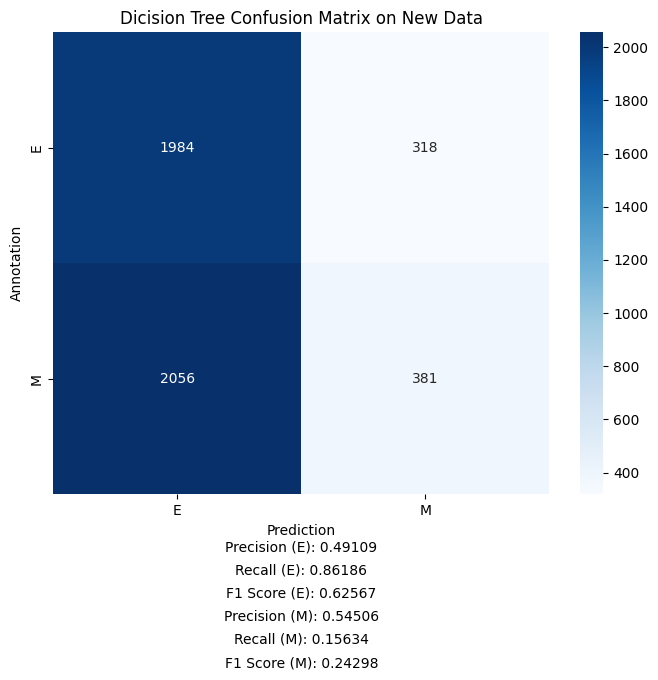

In [18]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', xticklabels=['E', 'M'], yticklabels=['E', 'M'])
plt.ylabel('Annotation')
plt.xlabel('Prediction')
plt.title('Dicision Tree Confusion Matrix on New Data')

# Calculate precision, recall, and F1 score for each class
precision_e = precision_score(y_new, y_new_pred, pos_label='E', average='binary')
recall_e = recall_score(y_new, y_new_pred, pos_label='E', average='binary')
f1_e = f1_score(y_new, y_new_pred, pos_label='E', average='binary')

# Display metrics for 'E' state in the plot
plt.text(0.5, -0.1, f"Precision (E): {precision_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.15, f"Recall (E): {recall_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.2, f"F1 Score (E): {f1_e:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Calculate metrics for 'M' state
precision_m = precision_score(y_new, y_new_pred, pos_label='M', average='binary')
recall_m = recall_score(y_new, y_new_pred, pos_label='M', average='binary')
f1_m = f1_score(y_new, y_new_pred, pos_label='M', average='binary')

# Display metrics for 'M' state in the plot
plt.text(0.5, -0.25, f"Precision (M): {precision_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.3, f"Recall (M): {recall_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.35, f"F1 Score (M): {f1_m:.5f}", ha='center', va='top', transform=plt.gca().transAxes, fontsize=10)

# Save the confusion matrix plot
plt.savefig("Metrics/dt_on_new_data_confusion_matrix.png", format='png', bbox_inches='tight')
plt.show()
plt.close()  # Free memory by closing figure